In [31]:
import os
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.optim as optim
import time
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import pyplot as plt
import optuna

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load Data

In [3]:
image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std = [0.229,0.224,0.225])
])

In [4]:
dataset_path = "./dataset"
dataset = datasets.ImageFolder(root=dataset_path,transform=image_transform)
len(dataset)

2300

In [5]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [7]:
num_classes = len(dataset.classes)
num_classes

6

In [8]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size
train_size,val_size

(1725, 575)

In [9]:
from torch.utils.data import random_split
train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

In [10]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=True)

In [11]:
for images,labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [12]:
labels[1]

tensor(2)

In [13]:
images[1].permute(1,0,2).shape

torch.Size([224, 3, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.5005665].


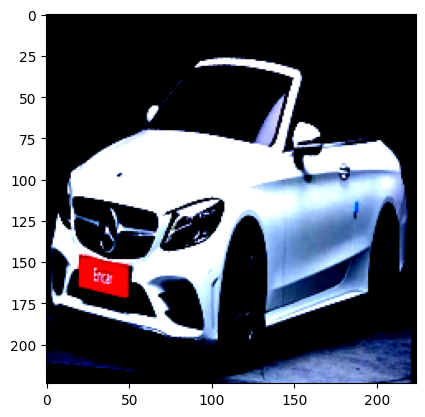

In [15]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

## Model 1 : CNN

In [17]:
class CarClassifierCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),#(16,224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#(16,112,112)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#(32,56,56)
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#(64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,num_classes)  
        )
    def forward(self,x):
        x = self.network(x)
        return x

In [18]:
#Instantiate model,loss function, optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterian = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [19]:
len(train_loader.dataset)

1725

In [20]:
def train_model(model,criterian,optimizer,epochs=10):
    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0

        for batch_num,(images,labels) in enumerate(train_loader):
            images,labels = images.to(device),labels.to(device)

            #zero the parameter gradiant
            optimizer.zero_grad()

            #forward pass
            outputs = model(images)
            loss = criterian(outputs,labels)

            #backward pass
            loss.backward()
            optimizer.step()

            if batch_num%10==0:
                print(f"Batch : {batch_num+1}, Epoch : {epoch+1}, Loss : {loss.item():.2f}")

            running_loss += loss.item()*images.size(0)

        epoch_loss = running_loss/len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}],Avg Loss: {epoch_loss: .4f}")

        #validation

        model.eval()
        correct = 0
        total = 0 
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images,labels in val_loader:
                images,labels = images.to(device), labels.to(device)
                outputs = model(images)
                _,predicted = torch.max(outputs.data,1)
                total+=labels.size(0)
                correct+=(predicted==labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            print(f"*** Validation Accuracy: {100*correct/total:.2f}% ***")

        end_time = time.time()
        print(f"Execution time: {end_time - start_time} seconds")
    return all_labels,all_predictions

In [26]:
all_labels, all_predictions=train_model(model,criterian,optimizer,epochs=10)

Batch : 1, Epoch : 1, Loss : 1.38
Batch : 11, Epoch : 1, Loss : 1.33
Batch : 21, Epoch : 1, Loss : 1.05
Batch : 31, Epoch : 1, Loss : 1.24
Batch : 41, Epoch : 1, Loss : 1.28
Batch : 51, Epoch : 1, Loss : 1.24
Epoch [1/10],Avg Loss:  1.1852
*** Validation Accuracy: 50.43% ***
Execution time: 62.39351201057434 seconds
Batch : 1, Epoch : 2, Loss : 1.01
Batch : 11, Epoch : 2, Loss : 1.39
Batch : 21, Epoch : 2, Loss : 1.06
Batch : 31, Epoch : 2, Loss : 0.91
Batch : 41, Epoch : 2, Loss : 1.16
Batch : 51, Epoch : 2, Loss : 1.13
Epoch [2/10],Avg Loss:  1.1076
*** Validation Accuracy: 51.83% ***
Execution time: 109.89717435836792 seconds
Batch : 1, Epoch : 3, Loss : 0.89
Batch : 11, Epoch : 3, Loss : 0.90
Batch : 21, Epoch : 3, Loss : 1.18
Batch : 31, Epoch : 3, Loss : 1.04
Batch : 41, Epoch : 3, Loss : 0.84
Batch : 51, Epoch : 3, Loss : 0.96
Epoch [3/10],Avg Loss:  1.0318
*** Validation Accuracy: 54.09% ***
Execution time: 157.21650624275208 seconds
Batch : 1, Epoch : 4, Loss : 0.71
Batch : 11

### Model 2 : CNN with Regularization

In [21]:
class CarClassifierCNNwithreg(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),#(16,224,224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#(16,112,112)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#(32,56,56)
            nn.ReLU(),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),#(64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,num_classes)  
        )
    def forward(self,x):
        x = self.network(x)
        return x

In [22]:
#Instantiate model,loss function, optimizer
model = CarClassifierCNNwithreg(num_classes=num_classes).to(device)
criterian = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)

In [35]:
all_labels, all_predictions=train_model(model,criterian,optimizer,epochs=10)

Batch : 1, Epoch : 1, Loss : 1.81
Batch : 11, Epoch : 1, Loss : 17.24
Batch : 21, Epoch : 1, Loss : 4.86
Batch : 31, Epoch : 1, Loss : 1.72
Batch : 41, Epoch : 1, Loss : 1.61
Batch : 51, Epoch : 1, Loss : 1.65
Epoch [1/10],Avg Loss:  9.5767
*** Validation Accuracy: 42.26% ***
Execution time: 47.42356038093567 seconds
Batch : 1, Epoch : 2, Loss : 1.38
Batch : 11, Epoch : 2, Loss : 1.60
Batch : 21, Epoch : 2, Loss : 1.10
Batch : 31, Epoch : 2, Loss : 1.04
Batch : 41, Epoch : 2, Loss : 1.08
Batch : 51, Epoch : 2, Loss : 1.12
Epoch [2/10],Avg Loss:  1.1898
*** Validation Accuracy: 53.22% ***
Execution time: 95.60733127593994 seconds
Batch : 1, Epoch : 3, Loss : 0.94
Batch : 11, Epoch : 3, Loss : 1.16
Batch : 21, Epoch : 3, Loss : 1.28
Batch : 31, Epoch : 3, Loss : 1.09
Batch : 41, Epoch : 3, Loss : 1.13
Batch : 51, Epoch : 3, Loss : 1.26
Epoch [3/10],Avg Loss:  1.0629
*** Validation Accuracy: 53.57% ***
Execution time: 142.75804090499878 seconds
Batch : 1, Epoch : 4, Loss : 1.19
Batch : 11

### Model 3: EfficientNet

In [23]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features,num_classes)
        )

    def forward(self,x):
        x=self.model(x)
        return x

In [24]:
#Instantiate model,loss function, optimizer
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterian = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=0.001)
train_model(model,criterian,optimizer,epochs=10)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\SANJAY KUMAR/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:23<00:00, 930kB/s]


Batch : 1, Epoch : 1, Loss : 1.80
Batch : 11, Epoch : 1, Loss : 1.60
Batch : 21, Epoch : 1, Loss : 1.49
Batch : 31, Epoch : 1, Loss : 1.57
Batch : 41, Epoch : 1, Loss : 1.28
Batch : 51, Epoch : 1, Loss : 1.33
Epoch [1/10],Avg Loss:  1.4892
*** Validation Accuracy: 57.57% ***
Execution time: 64.13946175575256 seconds
Batch : 1, Epoch : 2, Loss : 1.17
Batch : 11, Epoch : 2, Loss : 1.16
Batch : 21, Epoch : 2, Loss : 0.82
Batch : 31, Epoch : 2, Loss : 1.05
Batch : 41, Epoch : 2, Loss : 1.02
Batch : 51, Epoch : 2, Loss : 1.05
Epoch [2/10],Avg Loss:  1.0605
*** Validation Accuracy: 63.65% ***
Execution time: 110.81688070297241 seconds
Batch : 1, Epoch : 3, Loss : 1.00
Batch : 11, Epoch : 3, Loss : 0.98
Batch : 21, Epoch : 3, Loss : 0.85
Batch : 31, Epoch : 3, Loss : 0.76
Batch : 41, Epoch : 3, Loss : 0.97
Batch : 51, Epoch : 3, Loss : 0.86
Epoch [3/10],Avg Loss:  0.9056
*** Validation Accuracy: 64.17% ***
Execution time: 157.54425692558289 seconds
Batch : 1, Epoch : 4, Loss : 0.80
Batch : 11

([2,
  3,
  5,
  2,
  0,
  5,
  4,
  1,
  4,
  2,
  1,
  4,
  4,
  0,
  4,
  0,
  0,
  3,
  0,
  3,
  0,
  1,
  2,
  4,
  2,
  1,
  1,
  0,
  5,
  0,
  4,
  4,
  3,
  0,
  0,
  4,
  4,
  4,
  2,
  0,
  3,
  0,
  1,
  1,
  0,
  5,
  0,
  5,
  1,
  5,
  2,
  2,
  1,
  2,
  0,
  2,
  3,
  0,
  3,
  2,
  0,
  2,
  1,
  2,
  4,
  2,
  4,
  0,
  3,
  1,
  2,
  3,
  4,
  5,
  2,
  1,
  5,
  3,
  1,
  5,
  0,
  0,
  5,
  5,
  5,
  5,
  2,
  0,
  2,
  5,
  0,
  5,
  0,
  1,
  0,
  4,
  4,
  4,
  2,
  0,
  3,
  0,
  2,
  3,
  0,
  5,
  1,
  0,
  0,
  5,
  4,
  5,
  0,
  1,
  0,
  2,
  0,
  2,
  5,
  0,
  3,
  0,
  3,
  1,
  1,
  2,
  1,
  3,
  1,
  4,
  0,
  1,
  5,
  1,
  1,
  0,
  2,
  3,
  3,
  0,
  1,
  5,
  3,
  4,
  0,
  0,
  1,
  0,
  5,
  2,
  2,
  0,
  1,
  2,
  2,
  3,
  2,
  0,
  1,
  0,
  1,
  4,
  2,
  3,
  4,
  2,
  2,
  2,
  3,
  0,
  5,
  4,
  2,
  5,
  2,
  0,
  3,
  3,
  0,
  2,
  1,
  3,
  2,
  1,
  2,
  1,
  0,
  4,
  0,
  0,
  4,
  5,
  4,
  2,
  0,
  5,
  5,
  2,
  0,
  0,


### Model 4: Transfer Learning with ResNet

In [32]:
class CarClassifierResNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.layer4.parameters():
            param.requires_grad_ = True

        self.model.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.model.fc.in_features,num_classes)
        )

    def forward(self,x):
        x=self.model(x)
        return x

In [33]:
#Instantiate model,loss function, optimizer
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterian = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad,model.parameters()),lr=0.005)
labels,predictions = train_model(model,criterian,optimizer,epochs=50)

Batch : 1, Epoch : 1, Loss : 1.82
Batch : 11, Epoch : 1, Loss : 1.24
Batch : 21, Epoch : 1, Loss : 1.06
Batch : 31, Epoch : 1, Loss : 0.90
Batch : 41, Epoch : 1, Loss : 1.05
Batch : 51, Epoch : 1, Loss : 0.96
Epoch [1/50],Avg Loss:  1.1352
*** Validation Accuracy: 68.00% ***
Execution time: 48.642589807510376 seconds
Batch : 1, Epoch : 2, Loss : 0.70
Batch : 11, Epoch : 2, Loss : 0.91
Batch : 21, Epoch : 2, Loss : 0.72
Batch : 31, Epoch : 2, Loss : 0.75
Batch : 41, Epoch : 2, Loss : 0.57
Batch : 51, Epoch : 2, Loss : 0.62
Epoch [2/50],Avg Loss:  0.7099
*** Validation Accuracy: 66.96% ***
Execution time: 95.4612627029419 seconds
Batch : 1, Epoch : 3, Loss : 0.61
Batch : 11, Epoch : 3, Loss : 0.65
Batch : 21, Epoch : 3, Loss : 0.58
Batch : 31, Epoch : 3, Loss : 0.65
Batch : 41, Epoch : 3, Loss : 0.33
Batch : 51, Epoch : 3, Loss : 0.63
Epoch [3/50],Avg Loss:  0.5864
*** Validation Accuracy: 68.70% ***
Execution time: 142.03796410560608 seconds
Batch : 1, Epoch : 4, Loss : 0.38
Batch : 11,

### Classification Report 

In [34]:
from sklearn.metrics import classification_report

In [35]:
report = classification_report(labels,predictions)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.65      0.70       144
           1       0.56      0.63      0.59        92
           2       0.81      0.89      0.85       113
           3       0.62      0.71      0.66        72
           4       0.63      0.53      0.58        77
           5       0.73      0.73      0.73        77

    accuracy                           0.70       575
   macro avg       0.69      0.69      0.69       575
weighted avg       0.70      0.70      0.70       575

